In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import scipy
import scanpy as sc
import scvi

sc.set_figure_params(figsize=(4, 4))

This notebook is based on Katie's at `/project2/gilad/katie/ebQTL/ebQTL_lowpass_scVI_NB.ipynb`

In [ ]:
eb_adata = sc.read_h5ad("/project2/gilad/jpopp/ebQTL/data/single_cell_objects/Lowpass.3seqbatches.merged.TEMP.filtered.h5ad")

In [ ]:
sc.pp.highly_variable_genes(eb_adata, n_top_genes=3000, flavor='seurat_v3', subset=True)

In [ ]:
eb_adata

In [ ]:
scvi.data.setup_anndata(eb_adata, batch_key="library.prep.batch",
                        categorical_covariate_keys=['Collection.Date'])

In [ ]:
vae = scvi.model.SCVI(eb_adata, n_layers=2, n_latent=30,
                      gene_likelihood='nb')

In [ ]:
vae

In [ ]:
vae.train()

In [ ]:
eb_adata.write_h5ad("/project2/gilad/jpopp/ebQTL/data/single_cell_objects/Lowpass.3seqbatches.merged.scvi_input.h5ad")

In [ ]:
vae.save("/project2/gilad/jpopp/ebQTL/data/scvi_models/scvi_nb_ebonly_20211012", save_anndata=True)

In [ ]:
eb_adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(eb_adata, use_rep="X_scVI")
sc.tl.leiden(eb_adata)
sc.tl.umap(eb_adata)

In [ ]:
sc.pl.umap(eb_adata, color=['library.prep.batch'])

In [ ]:
eb_adata.write_h5ad("/project2/gilad/jpopp/ebQTL/data/single_cell_objects/Lowpass.3seqbatches.merged.scvi_processed.h5ad")

For further visualization it'll be useful to work with scaled data

In [ ]:
eb_adata.layers['counts'] = eb_adata.X
sc.pp.normalize_total(eb_adata)
sc.pp.log1p(eb_adata)
eb_adata.layers['lognorm'] = eb_adata.X
sc.pp.scale(eb_adata)
eb_adata.layers['scaled'] = eb_adata.X

In [ ]:
eb_adata.write_h5ad("/project2/gilad/jpopp/ebQTL/data/single_cell_objects/Lowpass.3seqbatches.merged.scvi_processed_and_scaled.h5ad")

## Marker Gene Annotation

In [ ]:
eb_adata = sc.read_h5ad("/project2/gilad/jpopp/ebQTL/data/single_cell_objects/Lowpass.3seqbatches.merged.scvi_processed_and_scaled.h5ad")

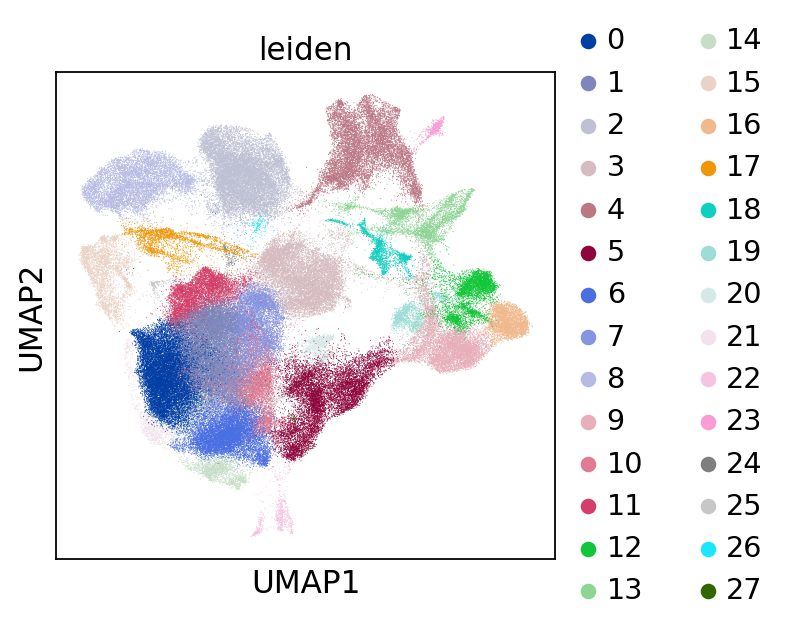

In [81]:
sc.pl.umap(eb_adata, color=['leiden'])

In [88]:
sc.tl.leiden(eb_adata, resolution=0.5, key_added='leiden_0.5')

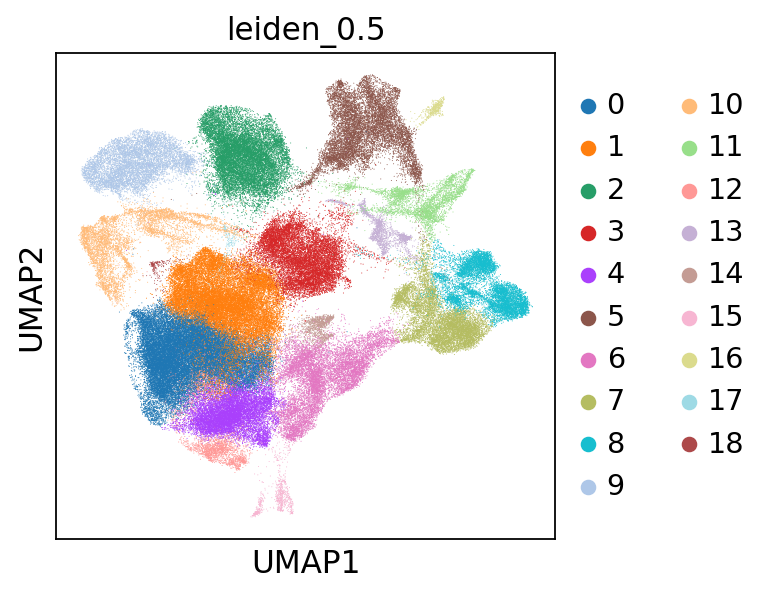

In [89]:
sc.pl.umap(eb_adata, color='leiden_0.5')

In [90]:
sc.tl.paga(eb_adata, groups='leiden_0.5')

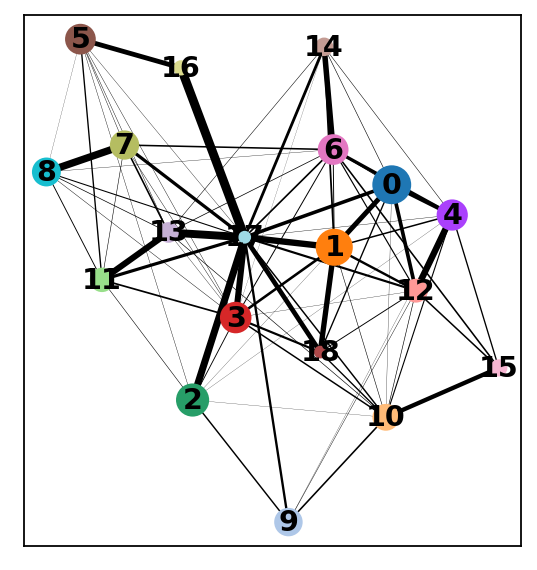

In [93]:
sc.pl.paga(eb_adata)

### Pluripotent Cells

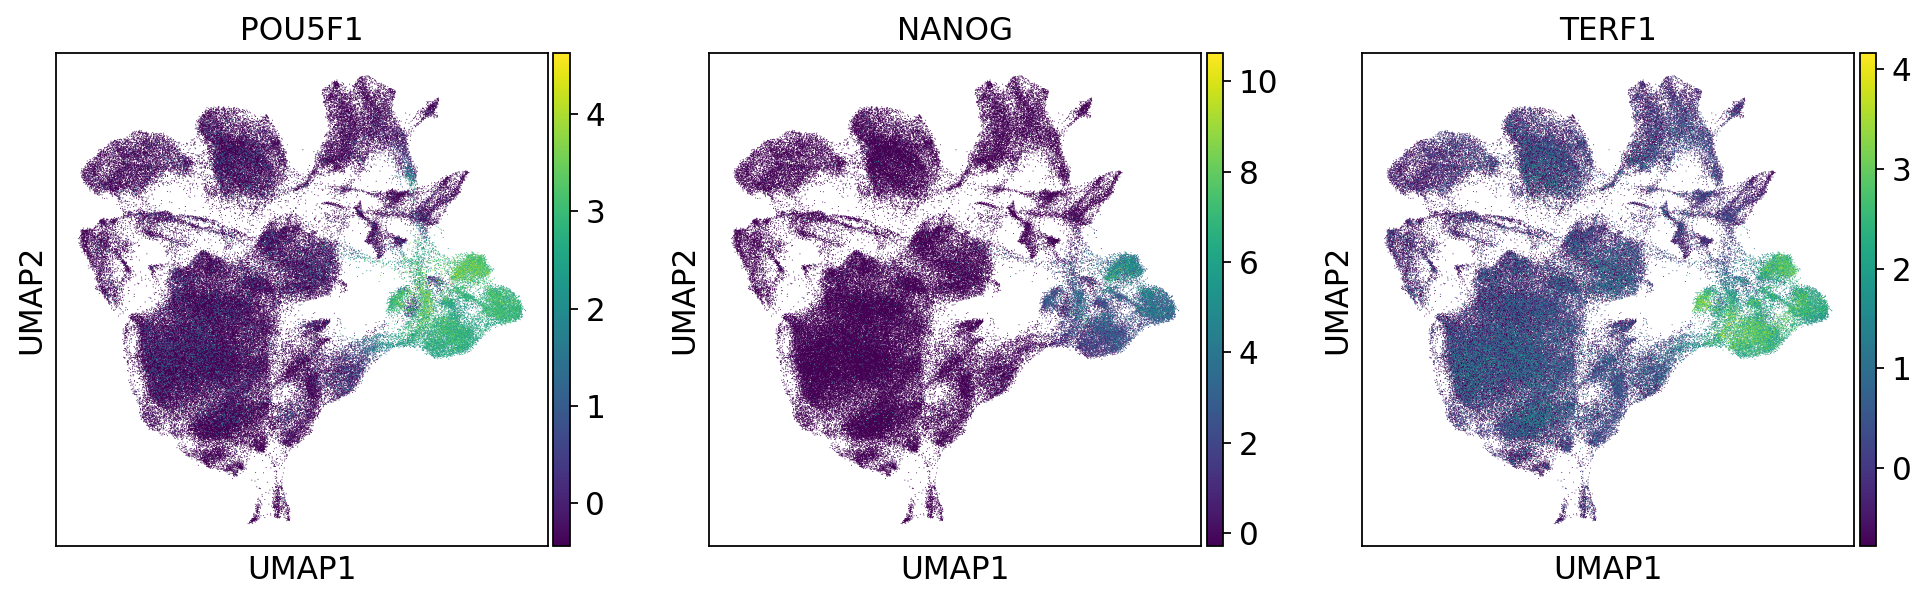

In [3]:
sc.pl.umap(eb_adata, color=['POU5F1', 'NANOG', 'TERF1'], use_raw=False)

Do the distinct clusters within iPSCs correspond to phases of the cell cycle?

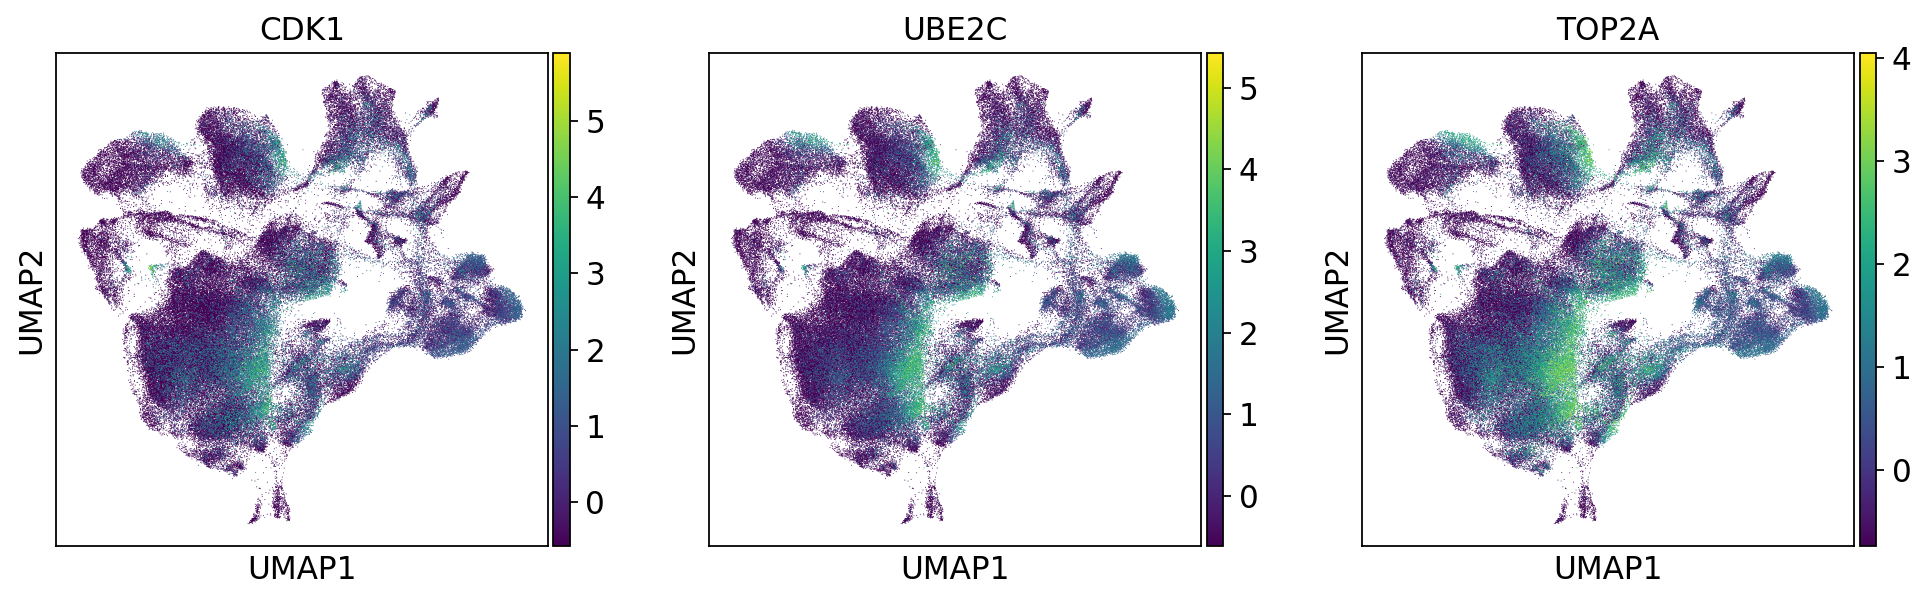

In [6]:
sc.pl.umap(eb_adata, color=['CDK1', 'UBE2C', 'TOP2A'], use_raw=False)

Probably not but we are seeing cell cycle effects in other clusters, although this also lines up with library size issues

In [ ]:
eb_adata

In [ ]:
sc.pl.umap(eb_adata, color=['CDK1', 'UBE2C', 'TOP2A'], use_raw=False)

### Mesoderm Lineage

Next, mesoderm lineage. EOMES is involved in both mesoderm and CNS development, MIXL1 is involved in mesoderm development.

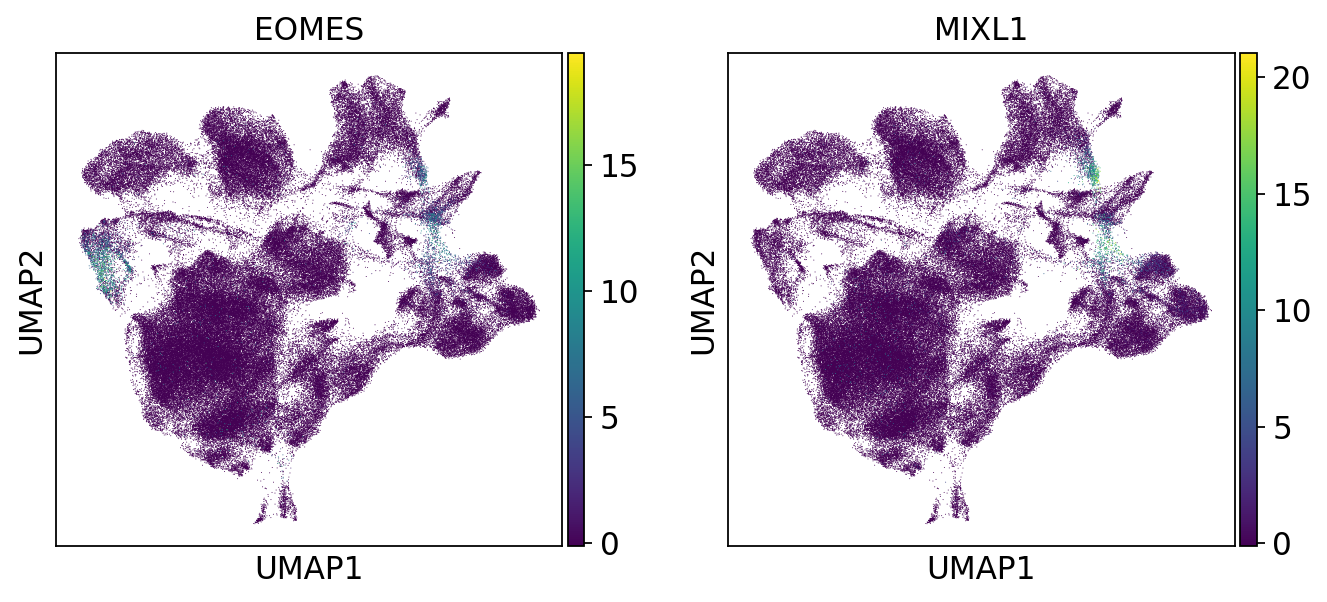

In [7]:
sc.pl.umap(eb_adata, color=['EOMES', 'MIXL1'], use_raw=False)

HAND1 is important in cardiac morphogenesis, and TNNT2 is expressed in cardiomyocytes. LUM is expressed in the kidney.

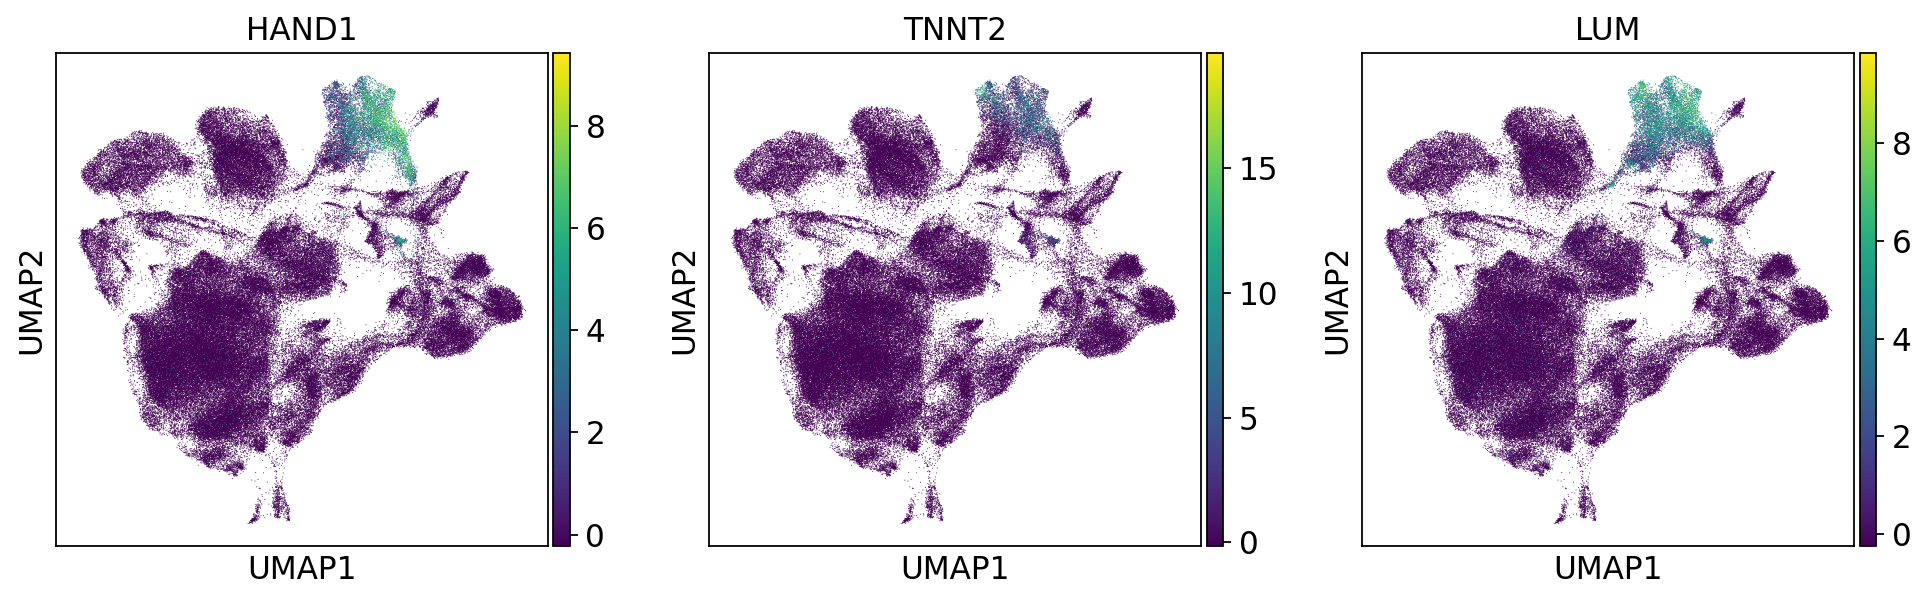

In [8]:
sc.pl.umap(eb_adata, color=['HAND1', 'TNNT2', 'LUM'], use_raw=False)

GNG11 is a marker for endothelial cells, a derivative of the mesoderm

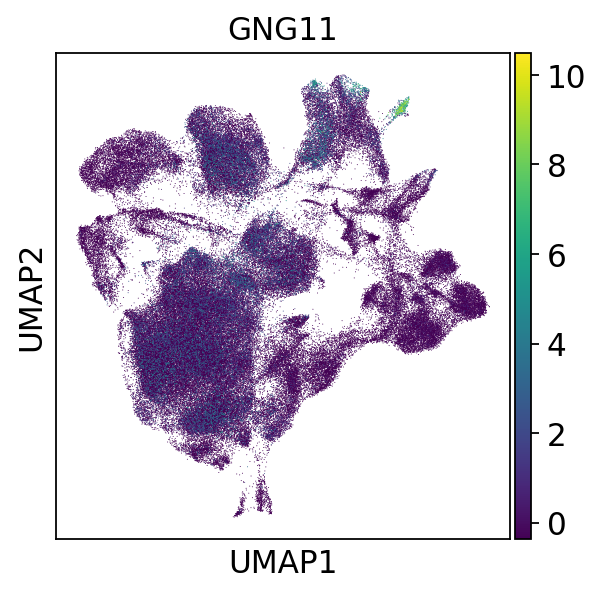

In [7]:
sc.pl.umap(eb_adata, color=['GNG11'], use_raw=False)

### Endoderm Lineage

Definition of early endoderm occurs when cells express GATA6 instead of continuing to express NANOG

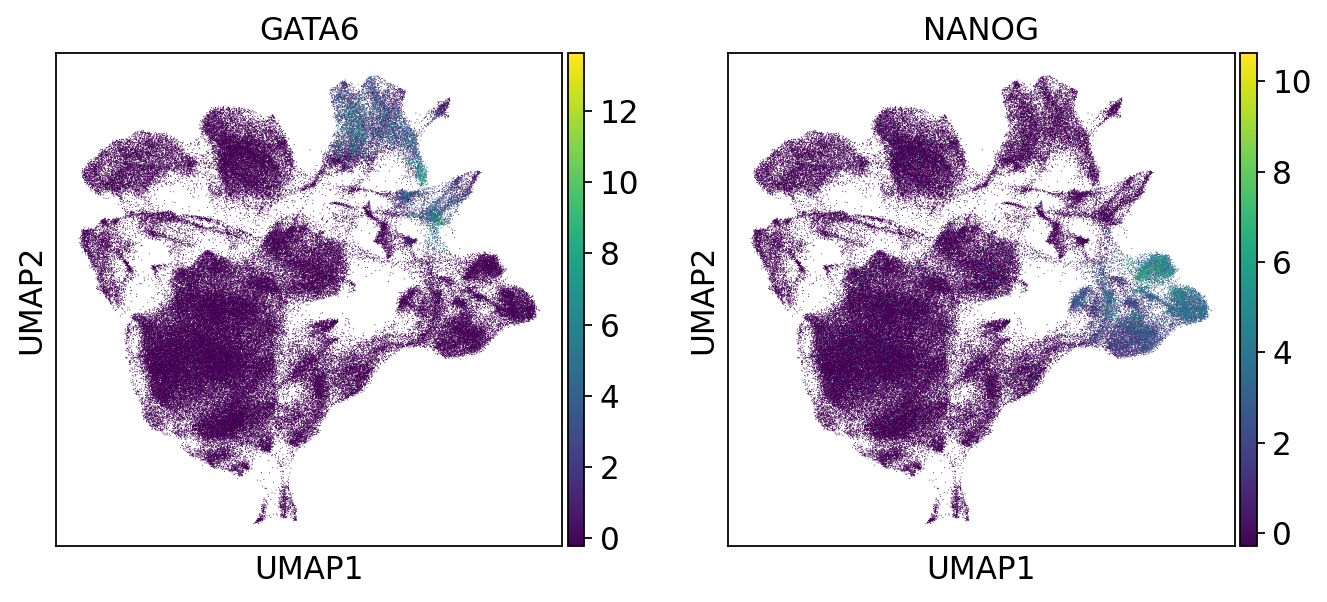

In [8]:
sc.pl.umap(eb_adata, color=['GATA6', 'NANOG'], use_raw=False)

AFP and FGB are expressed in hepatocytes (or perhaps hepatoblasts, a bi-potential precursor of hepatocytes)

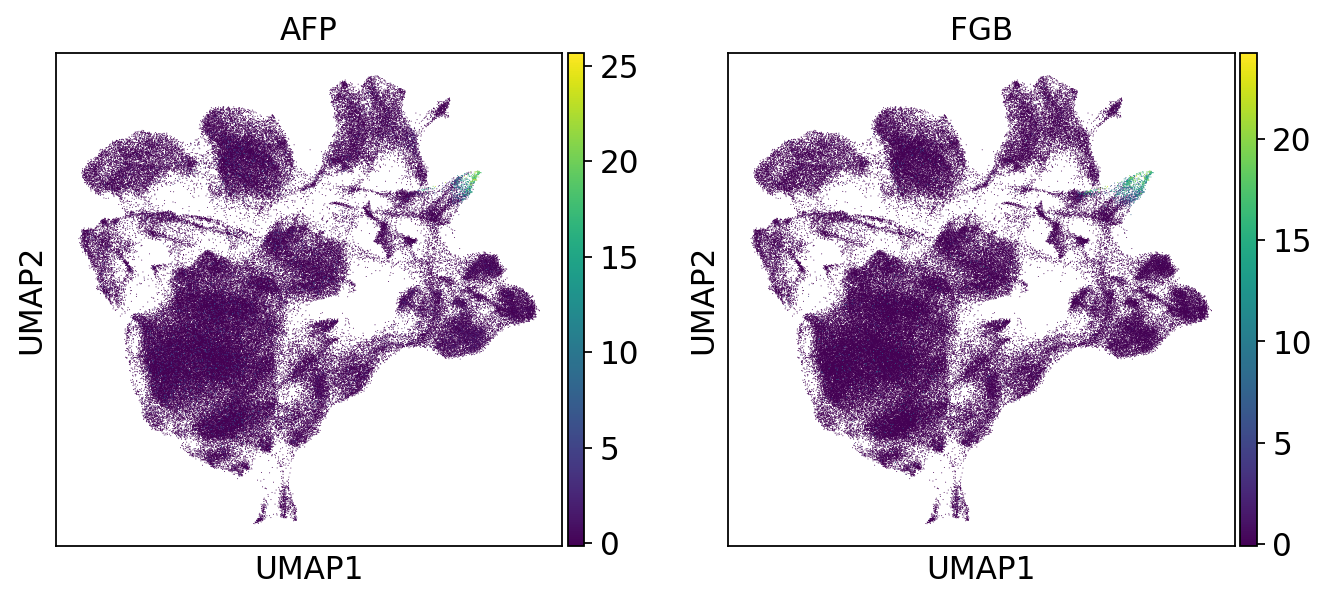

In [9]:
sc.pl.umap(eb_adata, color=['AFP', 'FGB'], use_raw=False)

### Ectoderm lineage

TPBG is a marker of trophoblast cells, which are the external cells of an early embryo. NEUROD1 is important in neural development (expressed in cerebellum in FCA), and SOX10 is important in neural crest and peripheral nervous system development (expressed in cerebrum in FCA). 

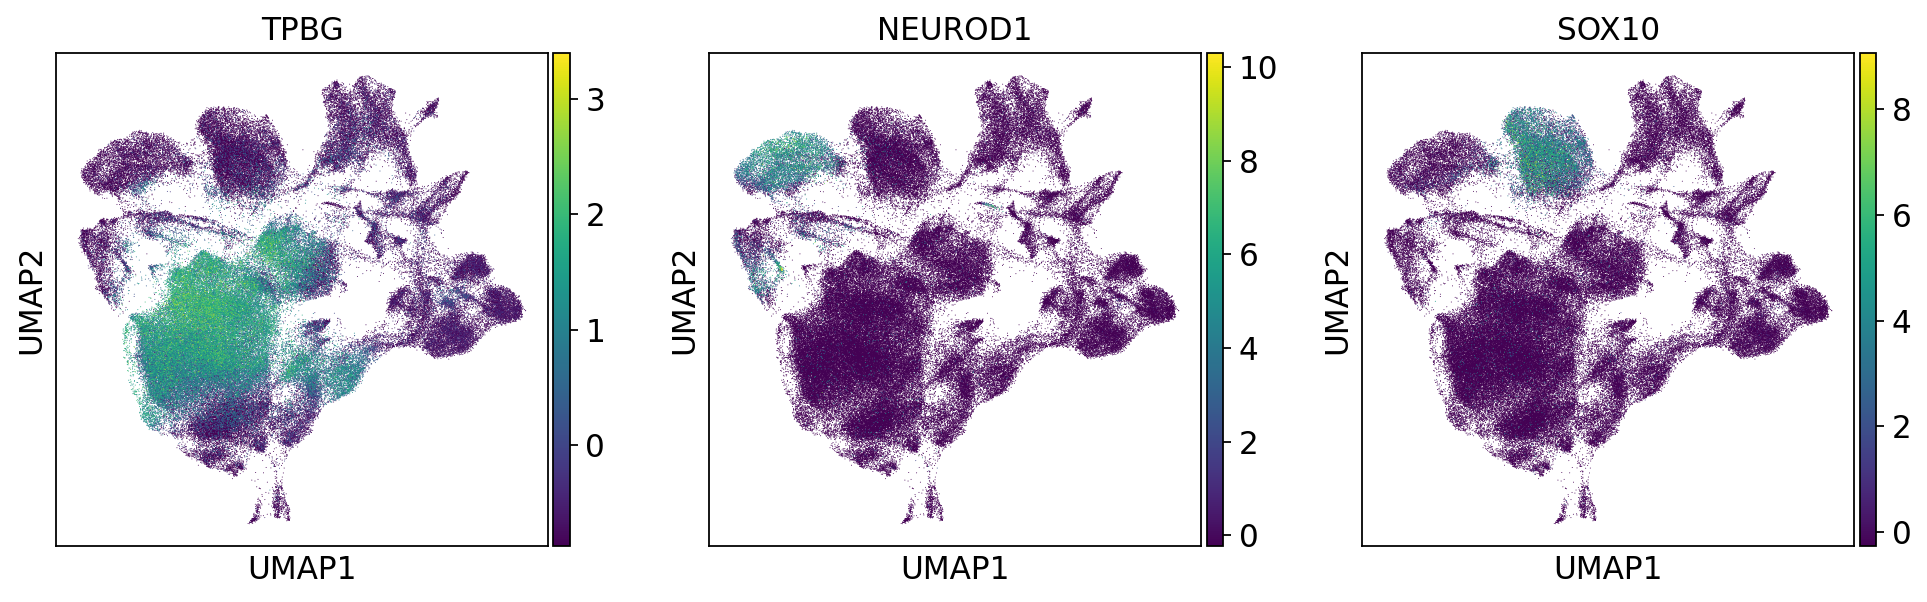

In [9]:
sc.pl.umap(eb_adata, color=['TPBG', 'NEUROD1', 'SOX10'], use_raw=False)

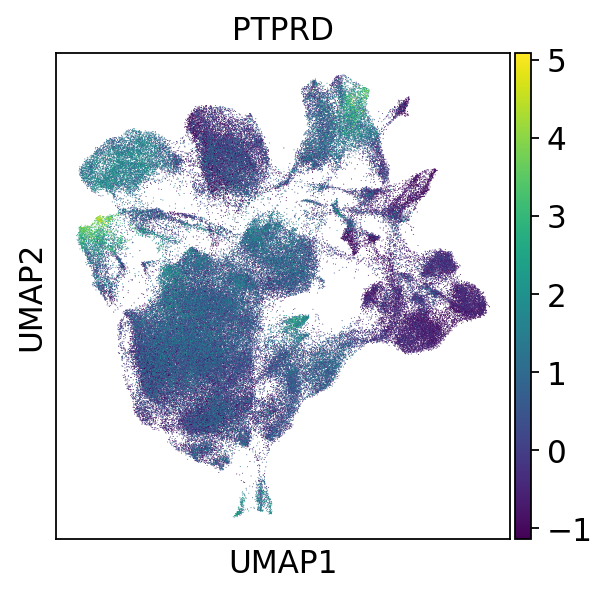

In [23]:
sc.pl.umap(eb_adata, color='PTPRD', use_raw=False)

## Even out cell type numbers

In [17]:
eb_adata.obs['leiden']

1001_1_AAACCCACAGAAGTGC-1     1
1001_1_AAACGAAAGGTATTGA-1    17
1001_1_AAACGAAAGTAGATCA-1    12
1001_1_AAACGAATCTCAGGCG-1    12
1001_1_AAACGCTAGCAGGTCA-1     8
                             ..
1019_2_TTTGTTGCAACACACT-1    12
1019_2_TTTGTTGCAAGTGATA-1     4
1019_2_TTTGTTGCACTAGGCC-1    17
1019_2_TTTGTTGCAGGGTCTC-1     4
1019_2_TTTGTTGCAGTCAACT-1     8
Name: leiden, Length: 153869, dtype: category
Categories (28, object): ['0', '1', '2', '3', ..., '24', '25', '26', '27']

## Cluster Analysis

Look at whether scVI factors are picking up on clear lineages

In [ ]:
for i in range(eb_adata.obsm['X_scVI'].shape[1]):
    eb_adata.obs['scVI_' + str(i+1)] = eb_adata.obsm['X_scVI'][:, i]

In [ ]:
sc.pl.umap(eb_adata, color=['scVI_1', 'scVI_2', 'scVI_3', 'scVI_4', 'scVI_5',
                           'scVI_6', 'scVI_7', 'scVI_8', 'scVI_9', 'scVI_10'])

Now look at the leiden clusters

In [ ]:
sc.pl.umap(eb_adata, color='leiden')

We can go for a slightly lower resolution to start off

In [ ]:
#eb_adata.obs['leiden_1.0'] = eb_adata.obs['leiden']
sc.tl.leiden(eb_adata, resolution=0.5, key_added='leiden_0.5')
sc.pl.umap(eb_adata, color='leiden_0.5')

In [ ]:
eb_adata.X = eb_adata.layers['lognorm']

In [ ]:
sc.tl.rank_genes_groups(eb_adata, groupby='leiden_0.5', groups=['0', '1', '4', '12', '15'])

In [ ]:
sc.pl.rank_genes_groups(eb_adata)

In [ ]:
eb_adata.obs['leiden_0.5'].value_counts()

### Reclustering with sampling

In [ ]:
cluster_assignments = pd.DataFrame(eb_adata.obs['leiden_0.5'])
cluster_assignments

In [ ]:
cluster_assignments.groupby('leiden_0.5').sample(500)

## 